In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!git clone https://github.com/cs4247/music-transcription.git

Cloning into 'music-transcription'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 44 (delta 16), reused 40 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 1.30 MiB | 5.95 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [3]:
os.chdir("music-transcription")

In [4]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.11-py3-none-any.whl size=5595886 sha256=e7d47801aa8b0e6eb49456310b6c9a1dd3d73075901b8dc92a6a3c1e7a879c28
  Stored in directory: /root/.cache/pip/wheels/09/e6/e6/29223dbea25e71e517b8791bf35cc9a7b872cb2ad284e30181
Successfully built pretty_midi


In [5]:
# Imports
import numpy as np
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
import matplotlib.pyplot as plt
from data.dataset import MaestroDataset
from torch.utils.data import DataLoader
import librosa.display


import torch
from torch.utils.data import Dataset
import pandas as pd
import librosa
import pretty_midi
# import numpy as np

In [6]:
# dataset.py

import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import librosa
import pretty_midi
import numpy as np

class MaestroDataset(Dataset):
    def __init__(self, root_dir, csv_path=None, year=None, split='train',
                 sr=16000, n_mels=229, hop_length=512, subset_size=None,
                 return_waveform: bool = False):
        """
        Load MAESTRO dataset with optional split filtering.
        Args:
            root_dir: path to maestro-v2.0.0/
            csv_path: optional path to metadata CSV
            year: optional specific year (e.g. "2017")
            split: one of {"train", "validation", "test"}
            subset_size: limit dataset size for debugging
        """
        self.root_dir = root_dir
        self.sr = sr
        self.n_mels = n_mels
        self.hop_length = hop_length

        # Load metadata CSV
        if csv_path is None:
            csv_path = os.path.join(root_dir, "maestro-v2.0.0.csv")
        self.df = pd.read_csv(csv_path)

        # Filter by year (optional). Accept single year or iterable of years or comma-separated string
        if year is not None:
            # normalize to list
            if isinstance(year, str) and "," in year:
                years = [int(y.strip()) for y in year.split(",") if y.strip()]
            elif isinstance(year, (list, tuple, set)):
                years = [int(y) for y in year]
            else:
                years = [int(year)]
            self.df = self.df[self.df["year"].isin(years)]

        # Filter by official MAESTRO split (train/validation/test)
        if split is not None:
            self.df = self.df[self.df["split"] == split]

        # Optionally take a small subset for debugging
        if subset_size:
            self.df = self.df.head(subset_size)

        self.df.reset_index(drop=True, inplace=True)
        self.return_waveform = return_waveform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = os.path.join(self.root_dir, row["audio_filename"])
        midi_path = os.path.join(self.root_dir, row["midi_filename"])

        # Convert .wav references to .mp3 if needed
        if not os.path.exists(audio_path) and audio_path.endswith(".wav"):
            audio_path = audio_path.replace(".wav", ".mp3")

        # Load and process audio ---
        y, _ = librosa.load(audio_path, sr=self.sr, mono=True)
        mel = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels, hop_length=self.hop_length)
        mel = librosa.power_to_db(mel).astype(np.float32)

        # Load and process MIDI ---
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        fs = self.sr / self.hop_length
        roll = midi_data.get_piano_roll(fs=fs)[21:109]  # 88 keys (A0–C8)
        roll = (roll > 0).astype(np.float32)

        # Align time frames between mel and roll
        min_len = min(mel.shape[1], roll.shape[1])
        mel = mel[:, :min_len]
        roll = roll[:, :min_len]

        # Convert to tensors
        mel_tensor = torch.tensor(mel).unsqueeze(0)  # (1, n_mels, T)
        roll_tensor = torch.tensor(roll)             # (88, T)
        waveform_tensor = torch.tensor(y.astype(np.float32))

        if self.return_waveform:
            # return raw waveform and roll for AST training
            return waveform_tensor, roll_tensor
        return mel_tensor, roll_tensor

In [7]:
!git switch transformer

Branch 'transformer' set up to track remote branch 'transformer' from 'origin'.
Switched to a new branch 'transformer'


In [8]:
# Initialize dataset
dataset = MaestroDataset(
    root_dir="/kaggle/input/themaestrodatasetv2/maestro-v2.0.0",
    year="2017",
    subset_size=5  # for quick loading
)

# Preview number of samples
print(f"Total samples: {len(dataset)}")

Total samples: 5


In [9]:
mel, roll = dataset[0]
print("Mel shape:", mel.shape)   # (1, n_mels, T)
print("Roll shape:", roll.shape) # (88, T)

Mel shape: torch.Size([1, 229, 14558])
Roll shape: torch.Size([88, 14558])


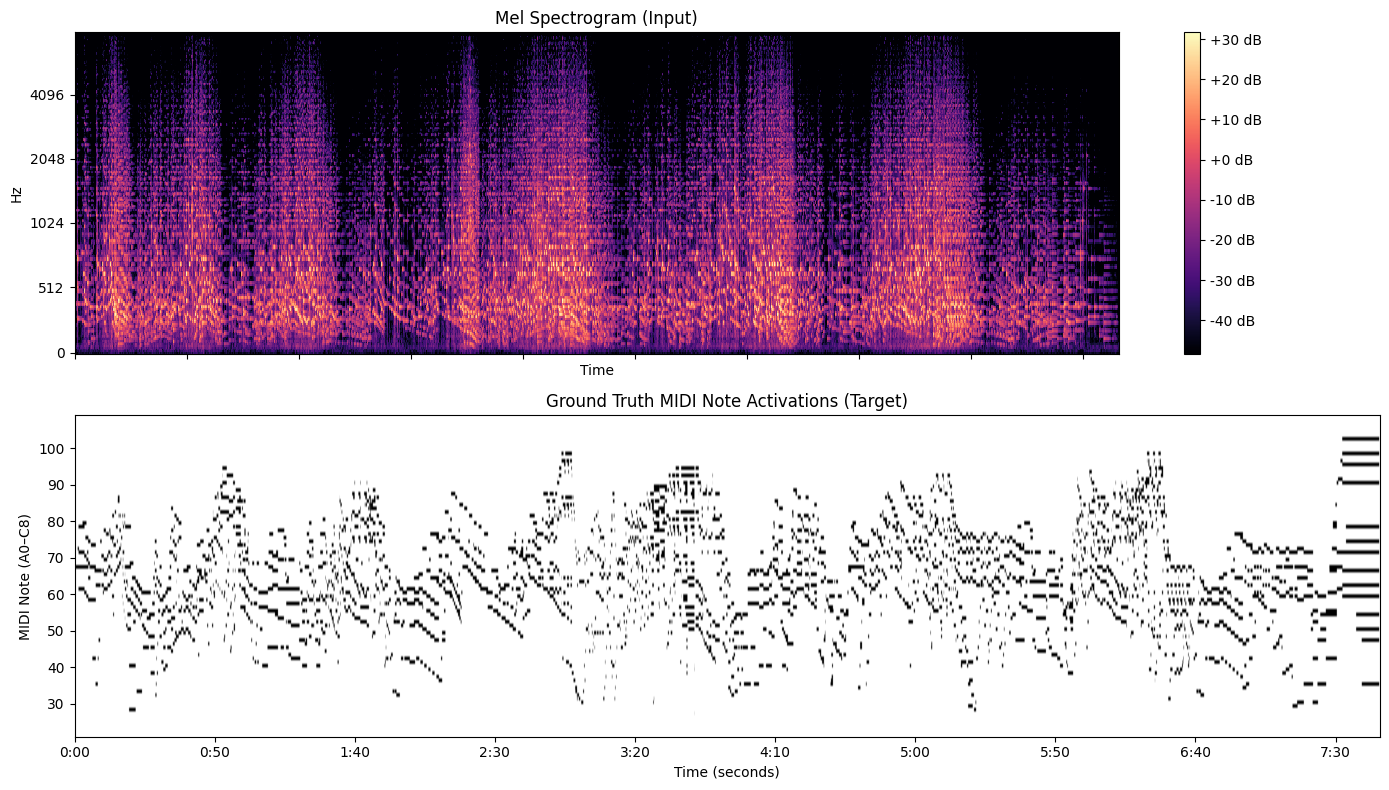

In [10]:
#plot spectrogram

import matplotlib.pyplot as plt
import librosa.display
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# --- 1. Mel Spectrogram ---
mel_db = mel.squeeze(0).numpy()

img = librosa.display.specshow(
    mel_db,
    sr=dataset.sr,
    hop_length=dataset.hop_length,
    x_axis="time",
    y_axis="mel",
    fmax=8000,
    cmap="magma",
    ax=ax[0]
)
fig.colorbar(img, ax=ax[0], format="%+2.0f dB")
ax[0].set_title("Mel Spectrogram (Input)")

# --- 2. MIDI Ground Truth ---
roll_np = roll.numpy()

ax[1].imshow(
    roll_np,
    aspect="auto",
    origin="lower",
    cmap="gray_r",
    extent=[0, roll_np.shape[1] * dataset.hop_length / dataset.sr, 21, 109],
)
ax[1].set_title("Ground Truth MIDI Note Activations (Target)")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("MIDI Note (A0–C8)")

plt.tight_layout()
plt.show()

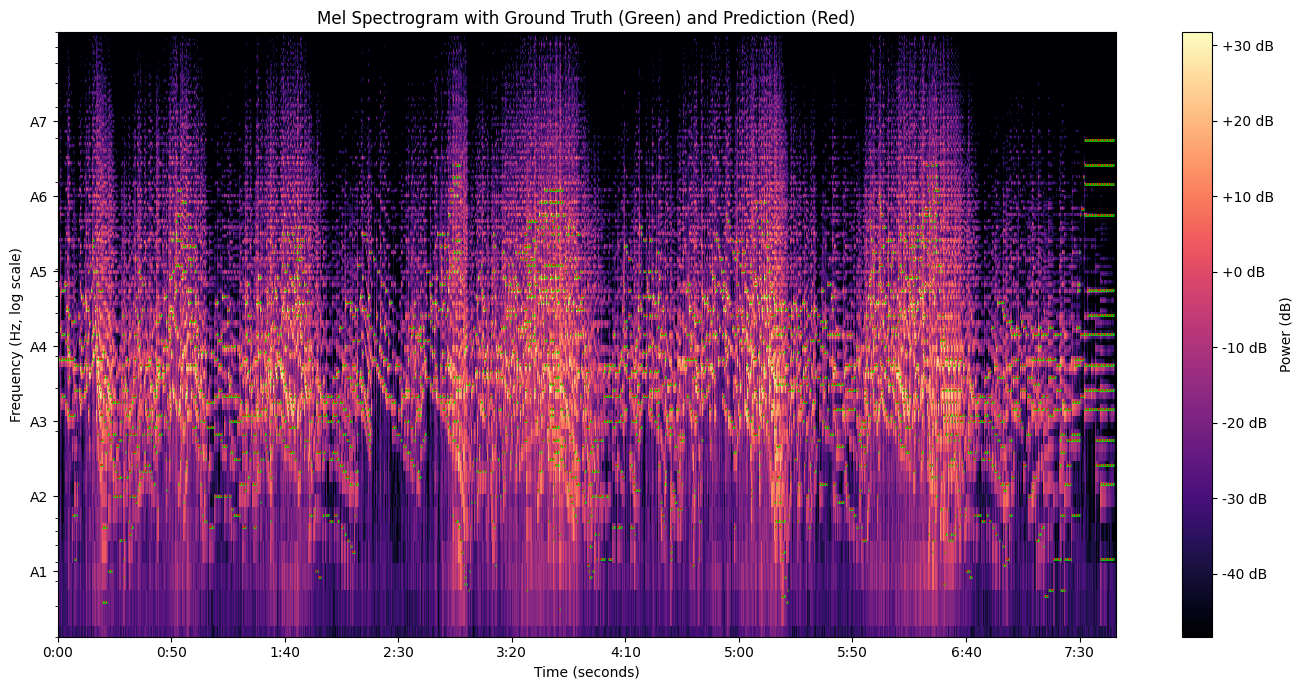

In [11]:
# plot overlay

import matplotlib.pyplot as plt
import librosa.display
import numpy as np

def plot_transcription_overlay(
    mel_db,
    roll_true,
    sr,
    hop_length,
    roll_pred=None,
    fmax=8000,
    title="Mel Spectrogram with MIDI Overlays"
):
    """
    Visualize mel spectrogram with optional ground-truth and predicted MIDI note overlays.

    Args:
        mel_db: np.ndarray of shape (n_mels, T)
        roll_true: np.ndarray of shape (88, T), ground-truth MIDI activations
        sr: sample rate
        hop_length: hop length used in STFT
        roll_pred: (optional) np.ndarray of shape (88, T), predicted activations
        fmax: upper limit of mel frequency display
    """
    times = np.arange(mel_db.shape[1]) * hop_length / sr

    plt.figure(figsize=(14, 7))

    # --- Mel Spectrogram ---
    img = librosa.display.specshow(
        mel_db,
        sr=sr,
        hop_length=hop_length,
        x_axis="time",
        y_axis="mel",
        fmax=fmax,
        cmap="magma",
    )
    plt.colorbar(img, format="%+2.0f dB", label="Power (dB)")

    # --- Overlay Ground Truth Notes ---
    for pitch in range(roll_true.shape[0]):
        active = roll_true[pitch] > 0
        if np.any(active):
            onset_idx = np.where(np.diff(np.concatenate(([0], active, [0]))) == 1)[0]
            offset_idx = np.where(np.diff(np.concatenate(([0], active, [0]))) == -1)[0]
            freq_hz = 440.0 * (2.0 ** ((21 + pitch - 69) / 12.0))
            for on, off in zip(onset_idx, offset_idx):
                plt.hlines(
                    y=freq_hz,
                    xmin=on * hop_length / sr,
                    xmax=off * hop_length / sr,
                    color="lime",
                    linewidth=2.0,
                    alpha=0.8,
                )

    # --- Overlay Predicted Notes (optional) ---
    if roll_pred is not None:
        for pitch in range(roll_pred.shape[0]):
            active = roll_pred[pitch] > 0
            if np.any(active):
                onset_idx = np.where(np.diff(np.concatenate(([0], active, [0]))) == 1)[0]
                offset_idx = np.where(np.diff(np.concatenate(([0], active, [0]))) == -1)[0]
                freq_hz = 440.0 * (2.0 ** ((21 + pitch - 69) / 12.0))
                for on, off in zip(onset_idx, offset_idx):
                    plt.hlines(
                        y=freq_hz,
                        xmin=on * hop_length / sr,
                        xmax=off * hop_length / sr,
                        color="red",
                        linewidth=1.5,
                        alpha=0.7,
                    )

    # --- Log-Frequency Scaling & Formatting ---
    plt.yscale("log")
    plt.ylim(30, fmax)
    plt.yticks(
        [55, 110, 220, 440, 880, 1760, 3520],
        ["A1", "A2", "A3", "A4", "A5", "A6", "A7"],
    )

    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz, log scale)")
    plt.tight_layout()
    plt.show()

mel_db = mel.squeeze(0).numpy()
roll_true = roll.numpy()

# Example: fake predictions (for demo)
roll_pred = roll_true.copy()
roll_pred[:, ::3] = 0  # pretend the model missed every third frame

plot_transcription_overlay(
    mel_db,
    roll_true,
    sr=dataset.sr,
    hop_length=dataset.hop_length,
    roll_pred=roll_pred,
    title="Mel Spectrogram with Ground Truth (Green) and Prediction (Red)"
)

In [12]:
#cnn_rnn_model.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNRNNModel(nn.Module):
    """
    Basic CNN + RNN model for automatic music transcription.
    
    Input:
        - Mel spectrogram tensor of shape (B, 1, n_mels, T)
    Output:
        - Predicted piano-roll logits of shape (B, 88, T)
          (before sigmoid activation)
    """

    def __init__(
        self,
        n_mels: int = 229,
        hidden_size: int = 256,
        num_layers: int = 2,
        dropout: float = 0.3,
    ):
        super().__init__()
        self.n_mels = n_mels
        self.hidden_size = hidden_size
        self.output_dim = 88  # added for consistency with zero-length fallback

        # --- CNN Frontend ---
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),  # downsample freq only

            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),  # downsample freq again
        )

        # --- Recurrent Layer (temporal modeling) ---
        freq_bins_after = n_mels // 4  # due to two (2×1) pools
        lstm_input_size = 64 * freq_bins_after

        self.rnn = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=True,
        )

        # --- Output Projection ---
        self.fc = nn.Linear(hidden_size * 2, self.output_dim)  # 88 piano keys

    def forward(self, x):
        # CNN feature extraction
        features = self.cnn(x)  # (B, C, F, T)
        features = features.permute(0, 3, 1, 2).contiguous()  # (B, T, C, F)
        B, T, C, F = features.shape
        features = features.view(B, T, C * F).contiguous()    # (B, T, C*F)

        # Defensive check for zero-length sequences
        if T == 0:
            return torch.zeros(B, self.output_dim, 1, device=x.device)

        # Run LSTM in FP32 for cuDNN stability (even under AMP)
        with torch.amp.autocast('cuda', enabled=False):
            rnn_out, _ = self.rnn(features.float())  # (B, T, 2*hidden_size)

        # Framewise projection → 88 keys
        logits = self.fc(rnn_out)       # (B, T, 88)
        return logits.transpose(1, 2)   # (B, 88, T)

In [13]:
#transcription_model.py
import torch
import torch.nn as nn
# from .cnn_rnn_model import CNNRNNModel
# from .transformer_model import ASTModel
# import torch.nn.functional as F
# from .remi_tokenizer import REMITokenizer

class TranscriptionModel(nn.Module):
    """
    High-level wrapper for automatic music transcription models.
    Handles:
      - model selection (currently CNN+RNN)
      - forward pass
      - loss computation
      - prediction thresholding (optional)
    """

    def __init__(
        self,
        model_type: str = "cnn_rnn",
        n_mels: int = 229,
        hidden_size: int = 256,
        num_layers: int = 2,
        dropout: float = 0.2,
        device: str = "cpu",
    ):
        super().__init__()

        self.model_type = model_type.lower()
        self.device = device

        if self.model_type in ["cnn_rnn", "cnn+rnn"]:
            self.model = CNNRNNModel(
                n_mels=n_mels,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout,
            )
        elif self.model_type in ["ast", "transformer", "audio_transformer"]:
            # ASTModel handles raw waveforms -> REMI token logits
            # Use smaller decoder dims by default to keep memory manageable
            self.model = ASTModel(device=device)
            # For token generation we use cross-entropy loss over vocab
            # REMITokenizer.pad == 2 by default; set ignore_index to pad id so padding tokens don't contribute
            self.criterion = nn.CrossEntropyLoss(ignore_index=2)
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        # Default criterion for framewise piano-roll models
        if not hasattr(self, "criterion"):
            # Binary cross-entropy loss (note-wise activation prediction)
            self.criterion = nn.BCEWithLogitsLoss()

        self.to(device)

    def forward(self, x, sampling_rate: int = 16000, targets: torch.LongTensor = None, generate_max_len: int = 256):
        """
        Forward pass through the model.
        Args:
            x: For `cnn_rnn`: (B, 1, n_mels, T)
               For `ast`: raw waveforms Tensor[B, L] or list of 1D tensors
            sampling_rate: sampling rate to pass to AST feature extractor
            targets: optional token targets for teacher forcing (AST)
            generate_max_len: when generating token ids (AST)
        Returns:
            logits: model-dependent. For `cnn_rnn`: (B, 88, T')
                    For `ast`: (B, T, V) token logits (when targets provided) or generated ids when called in generation mode via `predict`.
        """
        if self.model_type in ["ast", "transformer", "audio_transformer"]:
            return self.model(x, sampling_rate=sampling_rate, targets=targets, generate_max_len=generate_max_len)
        return self.model(x)

    def compute_loss(self, logits, targets, lengths=None):
        """
        Compute BCE loss between logits and ground truth piano-roll.
        If sequence lengths are provided, padded time frames are masked out.
        Args:
            logits: (B, 88, T')
            targets: (B, 88, T')
            lengths: (B,) or None — number of valid time steps per sample
        """
        # If using AST/token model, expect logits shaped (B, T, V) and targets (B, T)
        if self.model_type in ["ast", "transformer", "audio_transformer"]:
            # logits: (B, T, V), targets: (B, T)
            B, T, V = logits.shape

            # If targets are piano-rolls (B, 88, T_frames), convert to token sequences
            if torch.is_tensor(targets) and targets.dim() == 3:
                # Convert per-sample using tokenizer (perform on CPU)
                tokenizer = REMITokenizer(vocab_size=V)
                seqs = []
                max_len = T
                for i in range(targets.size(0)):
                    pr = targets[i].detach().cpu()
                    seq = tokenizer.encode_from_pianoroll(pr, max_len=max_len)
                    seqs.append(seq)
                targets = torch.tensor(seqs, dtype=torch.long, device=logits.device)

            # Now expect targets to be shape (B, T)
            if not torch.is_tensor(targets):
                targets = torch.as_tensor(targets, dtype=torch.long, device=logits.device)

            if targets.dim() != 2:
                raise ValueError(f"AST compute_loss expected targets shape (B, T) but got {tuple(targets.shape)}")

            # Flatten and compute cross-entropy
            loss = self.criterion(logits.view(-1, V), targets.view(-1))
            return loss
        # Align time if needed
        if logits.shape[-1] != targets.shape[-1]:
            logits = F.interpolate(logits, size=targets.shape[-1],
                                mode="linear", align_corners=False)

        # --- If no masking, just return regular BCE ---
        if lengths is None:
            return self.criterion(logits, targets)
        lengths = lengths.to(logits.device)

        # --- Apply mask ---
        B, P, T = logits.shape
        device = logits.device
        mask = torch.arange(T, device=device).unsqueeze(0) < lengths.unsqueeze(1)
        mask = mask.unsqueeze(1)  # shape (B, 1, T)

        # BCE without reduction
        loss_per_elem = F.binary_cross_entropy_with_logits(
            logits, targets, reduction='none'
        )  # shape (B, 88, T)

        # Zero out masked frames and average
        masked_loss = loss_per_elem * mask
        denom = mask.sum() * P  # total valid elements
        return masked_loss.sum() / denom.clamp_min(1)

    @torch.no_grad()
    def predict(self, x, threshold=0.5):
        """
        Inference method for note activation probabilities.
        Args:
            x: (B, 1, n_mels, T)
            threshold: float, decision threshold for activation
        Returns:
            piano_roll: binary tensor (B, 88, T')
        """
        if self.model_type in ["ast", "transformer", "audio_transformer"]:
            # AST model generation: forward with no targets triggers generation
            gen = self.forward(x)
            return gen

        logits = self.forward(x)
        probs = torch.sigmoid(logits)
        piano_roll = (probs > threshold).float()
        return piano_roll

In [14]:
# Remi tokenizer

# import torch
from typing import List, Tuple

class REMITokenizer:
    """Simple REMI-like tokenizer for testing and small-scale experiments.

    Vocabulary layout (small, deterministic):
      - 0: <sos>
      - 1: <eos>
      - 2: <pad>
      - 10-97: NOTE_ON_0 .. NOTE_ON_87  (pitch 0..87)
      - 110-197: NOTE_OFF_0 .. NOTE_OFF_87
      - 210-242: VELOCITY_0 .. VELOCITY_32 (coarse velocities)
      - 300-399: TIME_SHIFT_1 .. TIME_SHIFT_100 (time shift in frames)

    This is intentionally small and not a full REMI implementation. It
    provides encode/decode helpers to go between piano-rolls and token sequences
    so the transformer decoder can be trained/tested end-to-end.
    """

    def __init__(self, vocab_size: int = 512, max_time_shift: int = 100):
        self.vocab_size = vocab_size
        self.sos = 0
        self.eos = 1
        self.pad = 2

        self.note_on_base = 10
        self.note_off_base = 110
        self.velocity_base = 210
        self.time_shift_base = 300

        self.max_time_shift = max_time_shift

    def note_on_id(self, pitch: int) -> int:
        return self._safe_id(self.note_on_base + int(pitch))

    def note_off_id(self, pitch: int) -> int:
        return self._safe_id(self.note_off_base + int(pitch))

    def velocity_id(self, vel_idx: int) -> int:
        return self._safe_id(self.velocity_base + int(vel_idx))

    def time_shift_id(self, frames: int) -> int:
        frames = max(1, min(self.max_time_shift, int(frames)))
        return self._safe_id(self.time_shift_base + (frames - 1))

    def _safe_id(self, idx: int) -> int:
        """Ensure returned token id fits within vocab size; if not, return pad id.

        This prevents IndexError when the tokenizer's internal base offsets exceed
        the provided vocab_size (useful for tests with small vocabularies).
        """
        if idx < 0 or idx >= self.vocab_size:
            return self.pad
        return int(idx)

    def encode_from_pianoroll(self, piano_roll: torch.Tensor, frame_rate: int = 100, max_len: int = 256) -> List[int]:
        """Encode a piano-roll (88 x T) into a token sequence.

        Naive algorithm:
          - iterate frames t=0..T-1
          - if a note turns on at t (was 0 at t-1), emit NOTE_ON(pitch) + VELOCITY( default)
          - if a note turns off at t (was 1 at t-1), emit NOTE_OFF(pitch)
          - after processing frame, emit TIME_SHIFT_1

        Returns token id list (including <sos> and <eos>) truncated/padded to max_len.
        """
        # piano_roll: Tensor[88, T] or [T,88]
        pr = piano_roll
        if pr.dim() == 2 and pr.shape[0] != 88 and pr.shape[1] == 88:
            pr = pr.t()
        pr = pr.clone().float()
        if pr.shape[0] == 88:
            pr = pr.t()
        # now pr is (T, 88)
        T, P = pr.shape
        assert P == 88, "piano_roll must have 88 pitches"

        seq = [self.sos]
        prev = torch.zeros(88, dtype=torch.float32)
        for t in range(T):
            frame = pr[t]
            # note on
            ons = (frame > 0.5) & (prev <= 0.5)
            offs = (frame <= 0.5) & (prev > 0.5)
            for p in torch.nonzero(ons).squeeze(-1).tolist():
                seq.append(self.note_on_id(p))
                # coarse velocity index (single default)
                seq.append(self.velocity_id(0))
            for p in torch.nonzero(offs).squeeze(-1).tolist():
                seq.append(self.note_off_id(p))
            # time-shift of 1 frame
            seq.append(self.time_shift_id(1))
            prev = frame
            if len(seq) >= max_len - 1:
                break

        seq.append(self.eos)
        # pad or trim
        if len(seq) < max_len:
            seq = seq + [self.pad] * (max_len - len(seq))
        else:
            seq = seq[:max_len]
        return seq

    def decode_to_pianoroll(self, tokens: List[int], max_T: int = 1024) -> torch.Tensor:
        """Decode token sequence into a piano-roll (88, T) using simple semantics.

        Note: TIME_SHIFT tokens advance time by N frames.
        """
        T = max_T
        pr = torch.zeros(88, T, dtype=torch.float32)
        t = 0
        active = set()
        i = 0
        while i < len(tokens) and t < T:
            tok = tokens[i]
            if tok == self.sos:
                i += 1
                continue
            if tok == self.eos:
                break
            if self.note_on_base <= tok < self.note_off_base:
                pitch = tok - self.note_on_base
                active.add(pitch)
                # default velocity
                pr[pitch, t] = 1.0
                i += 1
                continue
            if self.note_off_base <= tok < self.velocity_base:
                pitch = tok - self.note_off_base
                if pitch in active:
                    active.remove(pitch)
                i += 1
                continue
            if self.time_shift_base <= tok < self.time_shift_base + self.max_time_shift:
                frames = (tok - self.time_shift_base) + 1
                # keep active notes for frames
                for ft in range(frames):
                    for p in active:
                        if t < T:
                            pr[p, t] = 1.0
                    t += 1
                i += 1
                continue
            # velocity or unknown token: skip
            i += 1

        return pr[:, :t]


In [15]:
# train_transcriber.py

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.amp import autocast, GradScaler
from tqdm import tqdm

# from data.dataset import MaestroDataset
# from models.transcription_model import TranscriptionModel
# from models.remi_tokenizer import REMITokenizer

import torch.nn.functional as F

from torch.amp import autocast

def collate_fn(batch, max_len=None):
    """
    Pad variable-length spectrograms and rolls to the same temporal length.
    Returns mel_batch, roll_batch, and valid lengths per sample.
    """
    mels, rolls = zip(*batch)
    lengths = [m.shape[-1] for m in mels]  # number of valid time frames
    max_T = max(lengths)

    mel_padded = [torch.nn.functional.pad(m, (0, max_T - m.shape[-1])) for m in mels]
    roll_padded = [torch.nn.functional.pad(r, (0, max_T - r.shape[-1])) for r in rolls]

    mel_batch = torch.stack(mel_padded)
    roll_batch = torch.stack(roll_padded)
    lengths = torch.tensor(lengths, dtype=torch.long)

    return mel_batch, roll_batch, lengths


def collate_ast(batch, max_token_len: int = 256):
    """Collate for AST model: expects each item to be (waveform, roll_or_tokens).

    If the second element is a piano-roll (Tensor with 88 pitches), encode it to tokens.
    Returns: list_of_waveforms, token_tensor (B, L)
    """
    tokenizer = REMITokenizer()
    waveforms, targets = zip(*batch)

    token_seqs = []
    for t in targets:
        # piano-roll detection: Tensor with one dimension == 88
        if isinstance(t, torch.Tensor) and t.dim() == 2 and (t.shape[0] == 88 or t.shape[1] == 88):
            seq = tokenizer.encode_from_pianoroll(t)
        else:
            # assume tokens list/1D tensor
            if isinstance(t, torch.Tensor):
                seq = t.tolist()
            else:
                seq = list(t)
            # pad/trim
            if len(seq) < max_token_len:
                seq = seq + [tokenizer.pad] * (max_token_len - len(seq))
            else:
                seq = seq[:max_token_len]
        token_seqs.append(seq)

    token_tensor = torch.tensor(token_seqs, dtype=torch.long)
    # waveforms may be tensors or numpy arrays; return as list and let model handle conversion
    waveforms_list = list(waveforms)
    return waveforms_list, token_tensor

def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    scaler = GradScaler()

    total_loss = 0.0
    step_losses = []

    # Initialize tqdm progress bar
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    # handle AST vs framewise training
    if getattr(model, "model_type", "cnn_rnn") in ["ast", "transformer", "audio_transformer"]:
        for batch in progress_bar:
            # Support variable batch structures (some collate fns may return 2- or 3-tuples)
            optimizer.zero_grad(set_to_none=True)

            # Unpack robustly
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                waveforms, token_targets = batch
            elif isinstance(batch, (list, tuple)) and len(batch) == 3:
                # some collates may return (waveforms, tokens, extra)
                waveforms, token_targets, _ = batch
            else:
                # fallback: assume batch is a dict-like from HF datasets
                try:
                    waveforms = batch[0]
                    token_targets = batch[1]
                except Exception:
                    raise ValueError("Unsupported batch format for AST training: %r" % (type(batch),))

            # Move targets to device; waveforms will be processed by model
            token_targets = token_targets.to(device)

            # Mixed-precision forward/backward
            with autocast('cuda'):
                logits = model(waveforms, sampling_rate=16000, targets=token_targets)
                loss = model.compute_loss(logits, token_targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            step_loss = loss.item()
            total_loss += step_loss
            step_losses.append(step_loss)
            progress_bar.set_postfix({"step_loss": f"{step_loss:.4f}"})
    else:
        for mel, roll, lengths in progress_bar:
            mel, roll = mel.to(device), roll.to(device)

            optimizer.zero_grad(set_to_none=True)

            # Mixed precision forward
            with autocast('cuda'):
                logits = model(mel)
                loss = model.compute_loss(logits, roll, lengths)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Update running totals
            step_loss = loss.item()
            total_loss += step_loss
            step_losses.append(step_loss)

            # Update tqdm bar dynamically
            progress_bar.set_postfix({"step_loss": f"{step_loss:.4f}"})

        # Update running totals
        step_loss = loss.item()
        total_loss += step_loss
        step_losses.append(step_loss)

        # Update tqdm bar dynamically
        progress_bar.set_postfix({"step_loss": f"{step_loss:.4f}"})

    avg_loss = total_loss / len(dataloader)
    progress_bar.close()
    return avg_loss, step_losses

# Validation helper
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        if getattr(model, "model_type", "cnn_rnn") in ["ast", "transformer", "audio_transformer"]:
            for batch in tqdm(dataloader, desc="Validation", leave=False):
                # Unpack robustly like in training
                if isinstance(batch, (list, tuple)) and len(batch) == 2:
                    waveforms, token_targets = batch
                elif isinstance(batch, (list, tuple)) and len(batch) == 3:
                    waveforms, token_targets, _ = batch
                else:
                    try:
                        waveforms = batch[0]
                        token_targets = batch[1]
                    except Exception:
                        raise ValueError("Unsupported batch format for AST validation: %r" % (type(batch),))

                token_targets = token_targets.to(device)
                with autocast('cuda'):
                    logits = model(waveforms, sampling_rate=16000, targets=token_targets)
                    loss = model.compute_loss(logits, token_targets)
                total_loss += loss.item()
        else:
            for mel, roll, lengths in tqdm(dataloader, desc="Validation", leave=False):
                mel, roll = mel.to(device), roll.to(device)
                with autocast('cuda'):
                    logits = model(mel)
                    loss = model.compute_loss(logits, roll, lengths)
                total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Main training function (can be imported in notebook)
def train_model(
    root_dir="maestro-v2.0.0",
    year="2017",
    batch_size=4,
    num_epochs=5,
    lr=1e-4,
    subset_size=None,
    device=None,
    save_path="checkpoints/cnn_rnn.pth",
    model_type: str = "cnn_rnn",
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Dataset ---
    # Model
    model = TranscriptionModel(model_type=model_type, device=device)

    # --- Dataset ---
    return_waveform = model_type in ["ast", "transformer", "audio_transformer"]
    train_set = MaestroDataset(root_dir=root_dir, year=year, subset_size=subset_size, return_waveform=return_waveform)
    val_set = MaestroDataset(root_dir=root_dir, year=year, subset_size=subset_size // 5 if subset_size else 10, return_waveform=return_waveform)

    if model_type in ["ast", "transformer", "audio_transformer"]:
        collate_used = collate_ast
    else:
        collate_used = collate_fn

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_used,
    )

    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        collate_fn=collate_used,
    )

    # Only optimize parameters that require gradients (encoder may be frozen)
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    if len(trainable_params) == 0:
        # fallback to all params to avoid empty optimizer
        trainable_params = model.parameters()
    optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=1e-2)

    best_val_loss = float("inf")

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        train_loss, step_losses = train_one_epoch(model, train_loader, optimizer, device)
        val_loss = evaluate(model, val_loader, device)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save model + optimizer state for resume
            ck = {
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
            }
            torch.save(ck, save_path)
            print(f"Saved new best model to {save_path}")

    return model

In [16]:
# main.py

import argparse
import os
from datetime import datetime
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# from data.dataset import MaestroDataset
# from train.train_transcriber import train_one_epoch, evaluate, collate_fn
# from models.transcription_model import TranscriptionModel


# Plot: per-epoch averaged losses
def plot_training_curves(train_losses, val_losses, save_path):
    """Plot and save loss curves."""
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", color="royalblue", linewidth=2)
    plt.plot(val_losses, label="Val Loss", color="tomato", linewidth=2)
    plt.title("Training and Validation Loss", fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Plot: per-step losses with epoch boundaries
def plot_step_losses(global_step_losses, num_epochs, save_path):
    """
    Plot per-step training loss across all epochs.

    Args:
        global_step_losses: list of lists, where each sublist = losses for that epoch
        num_epochs: total number of epochs (for x-axis scaling)
        save_path: file path for saving the figure
    """
    plt.figure(figsize=(10, 5))
    flat_losses = np.concatenate(global_step_losses)
    plt.plot(flat_losses, color="mediumseagreen", linewidth=1.2)
    plt.title("Training Loss per Step", fontsize=14)
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)

    # Add vertical lines to mark epoch boundaries
    step = 0
    for i, epoch_losses in enumerate(global_step_losses, 1):
        step += len(epoch_losses)
        plt.axvline(x=step, color="gray", linestyle="--", alpha=0.3)
        plt.text(step, plt.ylim()[1]*0.95, f"Epoch {i}", rotation=90,
                 fontsize=8, color="gray", va="top", ha="right")

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    
def main(args):
    parser = argparse.ArgumentParser(description="Train music transcription model")
    parser.add_argument("--root_dir", type=str, default="maestro-v2.0.0", help="Path to MAESTRO dataset root")
    parser.add_argument("--year", type=str, default=None, help="Subset year (e.g. 2017). Deprecated: prefer --years")
    parser.add_argument("--years", type=str, default=None, help="Comma-separated list of years to include (e.g. '2013,2017')")
    parser.add_argument("--batch_size", type=int, default=8, help="Batch size")
    parser.add_argument("--epochs", type=int, default=25, help="Number of training epochs")
    parser.add_argument("--lr", type=float, default=1e-4, help="Learning rate")
    parser.add_argument("--subset_size", type=int, default=None, help="Limit dataset size for debugging")
    parser.add_argument("--model_type", type=str, default="cnn_rnn", help="Model type: cnn_rnn or ast")
    parser.add_argument("--save_every", type=int, default=10, help="Save model checkpoint every N epochs")
    args = parser.parse_args(args)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    # print(torch.cuda.memory_summary(device=device, abbreviated=True)) GPU memory debugging

    # Output structure ---
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    run_dir = os.path.join("outputs", timestamp)
    checkpoint_dir = os.path.join(run_dir, "checkpoints")
    logs_dir = os.path.join(run_dir, "logs")
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(logs_dir, exist_ok=True)

    model_path = os.path.join(checkpoint_dir, "model_final.pth")
    loss_plot_path = os.path.join(logs_dir, "loss_curve.png")
    step_plot_path = os.path.join(logs_dir, "loss_per_step.png")

    # Data
    return_waveform = args.model_type in ["ast", "transformer", "audio_transformer"]

    # Support multiple years via --years (comma-separated) or single --year (backwards compat)
    years_arg = None
    if args.years:
        years_arg = args.years
    elif args.year:
        years_arg = args.year

    train_ds = MaestroDataset(args.root_dir, split="train", year=years_arg, subset_size=args.subset_size, return_waveform=return_waveform)
    val_ds   = MaestroDataset(args.root_dir, split="validation", year=years_arg, subset_size=args.subset_size, return_waveform=return_waveform)
    # test_ds  = MaestroDataset(args.root_dir, split="test", year=args.year)

    # Nicely formatted parameters.txt
    with open(os.path.join(logs_dir, "parameters.txt"), "w") as file:
        file.write("=== Training Parameters ===\n")
        file.write(f"Timestamp: {timestamp}\n")
        file.write(f"Device: {device}\n\n")
        for k, v in vars(args).items():
            file.write(f"{k:>15}: {v}\n")
        file.write(f"Training dataset size: {len(train_ds)}\n")
        file.write(f"Validation dataset size: {len(val_ds)}\n")

    if return_waveform:
        used_collate = collate_ast
    else:
        used_collate = collate_fn

    # On Kaggle kernels multiprocessing can be problematic; detect and use 0 workers there
    if os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None:
        num_workers = 0
    else:
        num_workers = min(4, (os.cpu_count() or 1))
    pin_memory = True if device.type == 'cuda' else False

    train_loader = DataLoader(
        train_ds,
        batch_size=args.batch_size,
        shuffle=True,
        collate_fn=used_collate,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=used_collate,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    # Model & optimizer
    model = TranscriptionModel(model_type=args.model_type, device=device)
    # Ensure model is on the correct device
    model.to(device)
    # Only optimize parameters that require gradients (encoder may be frozen)
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    if len(trainable_params) == 0:
        trainable_params = model.parameters()
    optimizer = optim.AdamW(trainable_params, lr=args.lr, weight_decay=1e-2)

    # Logging
    train_losses, val_losses = [], []
    global_losses = []  # list of per-step lists
    log_txt_path = os.path.join(logs_dir, "training_log.txt")

    with open(log_txt_path, "w") as log_file:
        log_file.write(f"Training started: {timestamp}\n")
        log_file.write(f"Device: {device}\n")
        log_file.write(f"Epochs: {args.epochs}, Batch size: {args.batch_size}, LR: {args.lr}\n\n")

        # Training loop
        for epoch in range(1, args.epochs + 1):
            print(f"\nEpoch {epoch}/{args.epochs}")
            # print(torch.cuda.memory_summary(device=device, abbreviated=True)) #GPU memory debugging

            train_loss, step_losses = train_one_epoch(model, train_loader, optimizer, device)
            val_loss = evaluate(model, val_loader, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            global_losses.append(step_losses)

            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            log_file.write(f"Epoch {epoch:02d}: Train={train_loss:.4f}, Val={val_loss:.4f}\n")
            log_file.flush()

            # Update training curve
            plot_training_curves(train_losses, val_losses, loss_plot_path)
            plot_step_losses(global_losses, args.epochs, step_plot_path)

            # Save checkpoint periodically
            if epoch % args.save_every == 0 or epoch == args.epochs:
                ckpt_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}.pth")
                torch.save(model.state_dict(), ckpt_path)
                print(f"Checkpoint saved to {ckpt_path}")

        # Final save
        torch.save(model.state_dict(), model_path)
        print(f"\nFinal model saved to {model_path}")
        log_file.write("\nTraining complete.\n")


# if __name__ == "__main__":
#     main()

In [17]:
# AST Model
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from models.remi_tokenizer import REMITokenizer

try:
    # Hugging Face imports (optional). If not installed, init will raise an informative error.
    from transformers import AutoFeatureExtractor, AutoModel
    _HF_AVAILABLE = True
except Exception:
    AutoFeatureExtractor = None
    AutoModel = None
    _HF_AVAILABLE = False


class ASTModel(nn.Module):
    """
    Audio Spectrogram Transformer encoder + Transformer decoder for REMI token generation.

    - Uses a pretrained AST encoder from Hugging Face (specified by `pretrained_model_name`).
    - Initially freezes encoder weights by default to reduce compute.
    - Transformer decoder generates REMI tokens autoregressively (teacher forcing during training).

    Input to forward():
      - waveforms: Tensor[B, L] or list of 1D Tensors (raw audio in float, range [-1,1])
      - sampling_rate: int (e.g., 16000)
      - targets (optional): LongTensor[B, T] of token ids for teacher forcing

    Returns:
      - If targets provided -> logits: Tensor[B, T, vocab_size]
      - Else -> generated token ids: Tensor[B, gen_len]
    """

    def __init__(
        self,
        pretrained_model_name: str = "MIT/ast-finetuned-audioset-10-10-0.4593",
        use_mock_encoder: bool = False,
        freeze_encoder: bool = True,
        remi_vocab_size: int = 512,
        decoder_layers: int = 4,
        decoder_dim: int = 384,
        decoder_heads: int = 6,
        dropout: float = 0.2,
        max_output_len: int = 1024,
        device: str = "cpu",
    ):
        super().__init__()

        self.device = device
        self.pretrained_model_name = pretrained_model_name
        self.freeze_encoder = freeze_encoder
        self.remi_vocab_size = remi_vocab_size
        self.decoder_dim = decoder_dim
        self.max_output_len = max_output_len
        self.use_mock_encoder = use_mock_encoder

        if self.use_mock_encoder:
            # Build a tiny mock feature extractor + encoder for unit tests (no HF download)
            class _MockFeatureExtractor:
                def __init__(self, hidden_size=64):
                    self.hidden_size = hidden_size

                def __call__(self, waveforms, sampling_rate=None, return_tensors="pt", padding=True):
                    # Return a dummy tensor shaped (B, S, hidden)
                    import numpy as _np
                    if isinstance(waveforms, list):
                        B = len(waveforms)
                        max_len = max([w.shape[0] if hasattr(w, 'shape') else len(w) for w in waveforms])
                    else:
                        waveforms = [waveforms]
                        B = 1
                        max_len = waveforms[0].shape[0]
                    S = max(1, max_len // 160)  # coarse time dimension
                    return {"input_values": torch.randn(B, S, self.hidden_size)}

            class _MockEncoder(nn.Module):
                def __init__(self, hidden_size=64):
                    super().__init__()
                    self.config = type("C", (), {"hidden_size": hidden_size})

                def forward(self, **kwargs):
                    x = kwargs.get("input_values")
                    # assume x is (B, S, H)
                    return type("O", (), {"last_hidden_state": x})

            self.feature_extractor = _MockFeatureExtractor(hidden_size=decoder_dim)
            self.encoder = _MockEncoder(hidden_size=decoder_dim)
        else:
            if not _HF_AVAILABLE:
                raise ImportError(
                    "The ASTModel requires `transformers` to be installed. "
                )

            # Feature extractor converts raw audio waveforms to log-mel patches expected by AST
            self.feature_extractor = AutoFeatureExtractor.from_pretrained(pretrained_model_name)

            # Pretrained AST encoder (we'll freeze its weights by default)
            self.encoder = AutoModel.from_pretrained(pretrained_model_name)

        # encoder hidden size (from model config)
        enc_hidden = getattr(self.encoder.config, "hidden_size", None)
        if enc_hidden is None:
            # fallback: try common attributes
            enc_hidden = getattr(self.encoder.config, "embed_dim", decoder_dim)

        # Freeze encoder if requested
        if freeze_encoder:
            for p in self.encoder.parameters():
                p.requires_grad = False

        # Project encoder features to decoder dimensionality
        self.enc_to_dec = nn.Linear(enc_hidden, decoder_dim)

        # Decoder token embeddings + positional embeddings
        self.token_emb = nn.Embedding(remi_vocab_size, decoder_dim)
        self.pos_emb = nn.Embedding(max_output_len, decoder_dim)

        # Transformer decoder stack
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=decoder_dim,
            nhead=decoder_heads,
            dim_feedforward=decoder_dim * 4,
            dropout=dropout,
            activation="gelu",
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=decoder_layers)

        # Final projection to REMI vocabulary
        self.output_fc = nn.Linear(decoder_dim, remi_vocab_size)

        # initialization helpers
        self._reset_parameters()

        self.to(device)

    def _reset_parameters(self):
        # small init for newly added heads
        nn.init.normal_(self.enc_to_dec.weight, mean=0.0, std=0.02)
        if self.enc_to_dec.bias is not None:
            nn.init.zeros_(self.enc_to_dec.bias)
        nn.init.normal_(self.output_fc.weight, mean=0.0, std=0.02)
        nn.init.zeros_(self.output_fc.bias)

    def _generate_square_subsequent_mask(self, sz: int):
        # PyTorch transformer expects float mask with -inf on illegal positions
        mask = torch.triu(torch.full((sz, sz), float("-inf")), diagonal=1)
        return mask

    def forward(self, waveforms, sampling_rate: int = 16000, targets: torch.LongTensor = None, generate_max_len: int = 256):
        """
        Forward pass.

        Args:
            waveforms: Tensor[B, L] or List[Tensor[B_i]] of raw audio float32 in [-1,1]
            sampling_rate: sampling rate used by the feature extractor
            targets: (optional) LongTensor[B, T] for teacher forcing
            generate_max_len: when generating, maximum tokens to produce
        """
        device = next(self.parameters()).device

        # Ensure waveforms are 1-D numpy arrays (the HF AST feature extractor uses
        # torchaudio/kaldi fbank under the hood and expects 1-D arrays). Users may
        # pass torch tensors or numpy arrays; convert torch tensors to numpy here.
        import numpy as _np

        if isinstance(waveforms, torch.Tensor):
            # tensor of shape (B, L) -> list of 1-D numpy arrays
            waveforms = [w.cpu().numpy().astype(_np.float32) for w in waveforms]
        elif isinstance(waveforms, (list, tuple)):
            converted = []
            for w in waveforms:
                if isinstance(w, torch.Tensor):
                    converted.append(w.cpu().numpy().astype(_np.float32))
                else:
                    # ensure numpy array dtype
                    try:
                        arr = _np.asarray(w, dtype=_np.float32)
                    except Exception:
                        arr = _np.array(w).astype(_np.float32)
                    converted.append(arr)
            waveforms = converted

        # Use feature_extractor to prepare inputs for encoder. It accepts lists or tensors.
        # It returns tensors on CPU by default; move them to device.
        # Ensure each waveform has a minimal length compatible with Kaldi fbank
        # (default frame_length in HF AST feature extractor is 25 ms -> 0.025 * sr samples)
        try:
            min_length = int(0.025 * float(sampling_rate)) if sampling_rate is not None else 400
        except Exception:
            min_length = 400
        for i, w in enumerate(waveforms):
            # ensure flat numpy array
            try:
                arr = _np.asarray(w, dtype=_np.float32).squeeze()
            except Exception:
                arr = _np.array(w, dtype=_np.float32).squeeze()
            if arr.ndim != 1:
                arr = arr.flatten()
            if arr.size < min_length:
                pad = _np.zeros(min_length - arr.size, dtype=_np.float32)
                arr = _np.concatenate([arr, pad])
            waveforms[i] = arr

        inputs = self.feature_extractor(waveforms, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
        # Move all tensors to model device
        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                inputs[k] = v.to(device)

        # Run encoder. Because encoder is large and often frozen, run under no_grad when frozen.
        if self.freeze_encoder:
            with torch.no_grad():
                enc_outputs = self.encoder(**inputs)
        else:
            enc_outputs = self.encoder(**inputs)

        # Hugging Face models often put sequence features in last_hidden_state
        enc_feats = getattr(enc_outputs, "last_hidden_state", None)
        if enc_feats is None:
            # try other common keys
            enc_feats = enc_outputs[0]

        # Project to decoder dim
        # enc_feats shape: (B, S, enc_hidden)
        dec_memory = self.enc_to_dec(enc_feats)  # (B, S, D)

        # Transformer decoder expects memory shape (S, B, D)
        memory = dec_memory.permute(1, 0, 2).contiguous()

        if targets is None:
            # Greedy autoregressive generation (CPU/GPU-friendly, not optimized)
            return self.generate(memory, sos_id=0, max_len=generate_max_len)

        # Teacher forcing path: produce logits for all time steps in targets
        # If targets is a piano-roll batch (B, 88, T) convert to token sequences
        if torch.is_tensor(targets) and targets.dim() == 3:
            # targets assumed (B, 88, T) or (B, T, 88)
            B = targets.size(0)
            tokenizer = REMITokenizer(vocab_size=self.remi_vocab_size)
            max_len = min(self.max_output_len, generate_max_len)
            seqs = []
            for i in range(B):
                pr = targets[i].detach().cpu()
                # encoder expects (88, T) or (T,88) — tokenizer will handle transposes
                seq = tokenizer.encode_from_pianoroll(pr, max_len=max_len)
                seqs.append(seq)
            targets = torch.as_tensor(seqs, dtype=torch.long, device=device)

        # If targets is a list of piano-rolls (numpy/torch), convert to token sequences first
        if not torch.is_tensor(targets) and isinstance(targets, (list, tuple)):
            # inspect first element to decide if it's piano-roll-like
            first = targets[0]
            is_pr = False
            try:
                import numpy as _np
                if isinstance(first, torch.Tensor) and first.dim() == 2 and (first.size(0) == 88 or first.size(1) == 88):
                    is_pr = True
                elif isinstance(first, (_np.ndarray, list)):
                    arr = _np.asarray(first)
                    if arr.ndim == 2 and (arr.shape[0] == 88 or arr.shape[1] == 88):
                        is_pr = True
            except Exception:
                is_pr = False

            if is_pr:
                tokenizer = REMITokenizer(vocab_size=self.remi_vocab_size)
                max_len = min(self.max_output_len, generate_max_len)
                seqs = []
                for pr in targets:
                    if isinstance(pr, torch.Tensor):
                        p = pr.detach().cpu()
                    else:
                        import numpy as _np
                        p = torch.as_tensor(_np.asarray(pr), dtype=torch.float32)
                    seq = tokenizer.encode_from_pianoroll(p, max_len=max_len)
                    seqs.append(seq)
                targets = torch.as_tensor(seqs, dtype=torch.long, device=device)
            else:
                targets = torch.as_tensor(targets, dtype=torch.long, device=device)
        else:
            targets = targets.to(device)

        # If there's an extra trailing singleton dim (e.g. shape (B, T, 1)), squeeze it
        if targets.dim() > 2 and targets.size(-1) == 1:
            targets = targets.squeeze(-1)

        if targets.dim() != 2:
            raise ValueError(f"Expected targets of shape (B, T) after normalization, got {tuple(targets.shape)}")

        # # Prepare decoder input and labels by shifting: decoder_input = targets[:, :-1]
        # # and labels = targets[:, 1:]. The training loop should pass labels to compute_loss.
        # if targets.size(1) < 2:
        #     # Nothing to predict
        #     return torch.empty((targets.size(0), 0, self.remi_vocab_size), device=device)

        # decoder_input = targets[:, :-1]
        # B, T_in = decoder_input.shape
        # positions = torch.arange(T_in, device=targets.device).unsqueeze(0).expand(B, T_in)
        # tgt_emb = self.token_emb(decoder_input) + self.pos_emb(positions)

        B, T = targets.shape
        positions = torch.arange(T, device=targets.device).unsqueeze(0).expand(B, T)
        tgt_emb = self.token_emb(targets) + self.pos_emb(positions)


        # Permute to shape (T, B, D) expected by nn.TransformerDecoder
        tgt_emb = tgt_emb.permute(1, 0, 2).contiguous()

        tgt_mask = self._generate_square_subsequent_mask(tgt_emb.size(0)).to(tgt_emb.device)

        # Decoder returns (T, B, D)
        dec_out = self.decoder(tgt_emb, memory, tgt_mask=tgt_mask)

        dec_out = dec_out.permute(1, 0, 2).contiguous()  # (B, T, D)
        logits = self.output_fc(dec_out)  # (B, T, V)
        return logits


    @torch.no_grad()
    def generate(
        self,
        memory,
        sos_id: int = 0,
        max_len: int = 256,
        do_sample: bool = False,
        temperature: float = 1.0,
        top_k: int = 0,
        mask_sos: bool = True,
        repetition_penalty: float = 0.0,
    ):
        """Autoregressive generation from the decoder using provided encoder memory.

        Backwards-compatible defaults produce the previous greedy behavior
        (do_sample=False, mask_sos=False, repetition_penalty=0.0).

        Args:
            memory: (S, B, D) encoder memory
            sos_id: start token id
            max_len: max tokens to generate
            do_sample: whether to sample from the softmax (vs argmax)
            temperature: softmax temperature when sampling
            top_k: if >0, restrict sampling to top_k logits
            mask_sos: if True, forbid emitting sos token after step 0
            repetition_penalty: float >=0. Subtracts penalty*count[token] from logits

        Returns:
            Tensor[B, L] of generated token ids
        """
        device = memory.device
        S, B, D = memory.shape
        vocab_size = self.remi_vocab_size

        generated = torch.full((B, 1), sos_id, dtype=torch.long, device=device)

        # counts per batch item for repetition penalty
        if repetition_penalty and repetition_penalty > 0.0:
            counts = torch.zeros((B, vocab_size), dtype=torch.long, device=device)
            # initialize with sos count
            counts.scatter_add_(1, generated, torch.ones_like(generated, dtype=torch.long))
        else:
            counts = None

        def top_k_logits(logits, k: int):
            if k <= 0:
                return logits
            values, _ = torch.topk(logits, k)
            min_values = values[..., -1, None]
            return torch.where(logits < min_values, torch.full_like(logits, float("-1e9")), logits)

        for step in range(max_len):
            positions = torch.arange(generated.size(1), device=device).unsqueeze(0).expand(B, -1)
            tgt_emb = self.token_emb(generated) + self.pos_emb(positions)
            tgt = tgt_emb.permute(1, 0, 2).contiguous()  # (T, B, D)
            tgt_mask = self._generate_square_subsequent_mask(tgt.size(0)).to(device)
            dec_out = self.decoder(tgt, memory, tgt_mask=tgt_mask)  # (T, B, D)
            last = dec_out[-1]  # (B, D)
            logits = self.output_fc(last)  # (B, V)

            # Optionally forbid producing sos after the first position
            if mask_sos and step > 0:
                if 0 <= sos_id < logits.size(-1):
                    logits[:, sos_id] = float("-1e9")

            # Apply repetition penalty (simple count-based subtraction)
            if counts is not None:
                # subtract penalty * counts (counts is integer tensor)
                logits = logits - repetition_penalty * counts.float()

            if do_sample:
                # sampling path: apply temperature and top_k filtering
                sample_logits = logits / max(1e-8, float(temperature))
                if top_k > 0:
                    sample_logits = top_k_logits(sample_logits, top_k)
                probs = torch.softmax(sample_logits, dim=-1)
                next_tokens = torch.multinomial(probs, num_samples=1)
            else:
                # greedy argmax
                next_tokens = logits.argmax(dim=-1, keepdim=True)

            # update counts if used
            if counts is not None:
                counts.scatter_add_(1, next_tokens, torch.ones_like(next_tokens, dtype=torch.long))

            generated = torch.cat([generated, next_tokens], dim=1)

        return generated[:, 1:]
    
    # @torch.no_grad()
    # def generate(self, memory, sos_id: int = 0, max_len: int = 256):
    #     """Greedy generation from the decoder using provided encoder memory.

    #     Args:
    #         memory: (S, B, D) encoder memory
    #         sos_id: start token id
    #         max_len: max tokens to generate
    #     Returns:
    #         Tensor[B, L] of generated token ids
    #     """
    #     device = memory.device
    #     S, B, D = memory.shape
    #     generated = torch.full((B, 1), sos_id, dtype=torch.long, device=device)

    #     for step in range(max_len):
    #         positions = torch.arange(generated.size(1), device=device).unsqueeze(0).expand(B, -1)
    #         tgt_emb = self.token_emb(generated) + self.pos_emb(positions)
    #         tgt = tgt_emb.permute(1, 0, 2).contiguous()  # (T, B, D)
    #         tgt_mask = self._generate_square_subsequent_mask(tgt.size(0)).to(device)
    #         dec_out = self.decoder(tgt, memory, tgt_mask=tgt_mask)  # (T, B, D)
    #         last = dec_out[-1]  # (B, D)
    #         logits = self.output_fc(last)  # (B, V)
    #         next_tokens = logits.argmax(dim=-1, keepdim=True)  # (B,1)
    #         generated = torch.cat([generated, next_tokens], dim=1)
    #     return generated[:, 1:]



In [18]:
# Driver code -- Training

# CNN+RNN
# main(["--root_dir", "/kaggle/input/themaestrodatasetv2/maestro-v2.0.0",
#     "--year", "2017", 
#       "--epochs", "5", 
#       "--batch_size", "1", 
#       "--lr", "1e-4", 
#       "--save_every", "5",
#       "--subset_size", "100"])


# AST 
main(["--root_dir", "/kaggle/input/themaestrodatasetv2/maestro-v2.0.0",
    "--years", "2004,2006,2008,2009,2011,2013,2014,2015,2017, 2018", 
      "--epochs", "2", 
      "--batch_size", "4", 
      "--lr", "1e-4", 
      "--save_every", "2",
      "--subset_size", "2000",
      "--model_type", "transformer"])

Using device: cuda


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Epoch 1/2


Train Loss: 0.7593 | Val Loss: 0.1016

Epoch 2/2


Train Loss: 0.0647 | Val Loss: 0.0266
Checkpoint saved to outputs/2025-12-08_18-13-50/checkpoints/model_epoch_2.pth

Final model saved to outputs/2025-12-08_18-13-50/checkpoints/model_final.pth


In [19]:
# # AST test

# def test_ast_forward_mock():
#     # small mock encoder to avoid HF downloads
#     model = ASTModel(pretrained_model_name=None, use_mock_encoder=True, remi_vocab_size=128, decoder_dim=64, decoder_layers=2, decoder_heads=8, device="cpu")
#     # model = ASTModel(pretrained_model_name=None, use_mock_encoder=True, remi_vocab_size=128, decoder_dim=64, decoder_layers=2, device="cpu")
#     tokenizer = REMITokenizer(vocab_size=128)

#     # create a dummy piano-roll: 88 x 50 frames, a C4 note on at frame 5, off at 20
#     pr = torch.zeros(88, 50)
#     pr[60, 5:20] = 1.0  # middle C approx

#     tokens = tokenizer.encode_from_pianoroll(pr, max_len=64)
#     tokens_tensor = torch.tensor([tokens], dtype=torch.long)

#     # Create a dummy waveform (batch of 1)
#     waveform = [torch.randn(16000)]

#     # Forward (teacher forcing)
#     logits = model(waveform, sampling_rate=16000, targets=tokens_tensor)
#     print('logits shape:', logits.shape)
#     assert logits.ndim == 3

#     # Generation (no targets)
#     gen = model(waveform, sampling_rate=16000, targets=None, generate_max_len=8)
#     print('generated:', gen.shape)
#     assert gen.ndim == 2


# if __name__ == '__main__':
#     test_ast_forward_mock()


In [20]:
# # Test forward pass

# # import torch
# # from models.transformer_model import ASTModel

# # # small smoke test: create model and do a forward with fake data
# # model = ASTModel(pretrained_model_name='MIT/ast-finetuned-audioset-10-10-0.4593', freeze_encoder=True, device='cpu')
# # # create a batch of 2 short random waveforms in [-1,1]
# # waveforms = [torch.randn(16000) for _ in range(2)]
# # # run with teacher_forcing disabled -> generation (greedy) path (should return token ids)
# # out = model(waveforms, sampling_rate=16000, targets=None, generate_max_len=8)
# # print('generated shape:', out.shape)


# model = ASTModel(device='cpu')  # may download HF weights
# waveforms_torch = [torch.randn(16000) for _ in range(2)]
# out = model(waveforms_torch, sampling_rate=16000, targets=None, generate_max_len=4)
# print('generated shape (torch input):', out.shape)

# # also test numpy input
# waveforms_np = [np.random.randn(16000).astype(np.float32) for _ in range(2)]
# out2 = model(waveforms_np, sampling_rate=16000, targets=None, generate_max_len=4)
# print('generated shape (numpy input):', out2.shape)

# AST model → generate REMI tokens → decode to MIDI
This notebook loads a trained AST model checkpoint, runs inference on a sample audio file, decodes generated REMI tokens to a piano-roll, and writes a MIDI file.
Notes:

    - The code expects the repository code (this project) to be available in the notebook working directory.
    - If you run on Kaggle, ensure GPU is enabled in the notebook settings.
    - The REMI tokenizer uses frame-based time shifts. We assume a frame rate (frames/sec) of 100 when converting frames to seconds. This is approximate and depends on how the tokenizer / collate were configured during training.

In [21]:
# # End-to-end inference test: load checkpoint, run AST generate, decode to MIDI
# import os
# import torch
# import librosa
# import numpy as np
# import pretty_midi

# # from models.transcription_model import TranscriptionModel
# # from models.remi_tokenizer import REMITokenizer

# # === USER CONFIG ===
# CHECKPOINT_PATH = "/kaggle/input/transcription-ast/pytorch/default/1/model_epoch_40.pth"   # path to your weights file
# SAMPLE_AUDIO_PATH = "/kaggle/input/themaestrodatasetv2/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.mp3"  # path to .wav/.mp3 to transcribe
# OUT_MIDI_PATH = "/kaggle/working/generated_from_audio.mid"   # where to save output MIDI
# SAMPLE_SR = 16000            # sampling rate to use for model (must match training)
# GENERATE_MAX_LEN = 1024      # max token length to generate
# # =====================

# assert os.path.exists(CHECKPOINT_PATH), f"Checkpoint not found: {CHECKPOINT_PATH}"
# assert os.path.exists(SAMPLE_AUDIO_PATH), f"Audio file not found: {SAMPLE_AUDIO_PATH}"

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# # 1) Instantiate model (AST path)
# model = TranscriptionModel(model_type='transformer', device=device)
# model.to(device)
# model.eval()

# # 2) Load checkpoint (support several common dict shapes)
# ck = torch.load(CHECKPOINT_PATH, map_location=device)
# if isinstance(ck, dict):
#     # common keys: 'model_state', 'model_state_dict', 'state_dict'
#     if "model_state" in ck:
#         state = ck["model_state"]
#     elif "model_state_dict" in ck:
#         state = ck["model_state_dict"]
#     elif "state_dict" in ck:
#         state = ck["state_dict"]
#     else:
#         # assume entire dict is the state_dict if shapes match, else try heuristic
#         state = ck
# else:
#     state = ck

# # If saved state dict contains 'module.' prefixes (DataParallel), remove them
# def fix_state_dict(sd):
#     new_sd = {}
#     for k, v in sd.items():
#         nk = k
#         if k.startswith("module."):
#             nk = k[len("module."):]
#         new_sd[nk] = v
#     return new_sd

# if isinstance(state, dict):
#     try:
#         model.load_state_dict(state)
#     except RuntimeError:
#         # try strip 'module.' prefixes
#         fixed = fix_state_dict(state)
#         model.load_state_dict(fixed)

# print("Loaded model weights from", CHECKPOINT_PATH)

# # 3) Load audio and prepare waveform
# y, orig_sr = librosa.load(SAMPLE_AUDIO_PATH, sr=SAMPLE_SR, mono=True)
# wave_np = y.astype(np.float32)
# print(f"Loaded audio {SAMPLE_AUDIO_PATH} (duration {len(y)/SAMPLE_SR:.2f}s)")

# # 4) Run generation (greedy)
# with torch.no_grad():
#     # TranscriptionModel.forward expects either waveform tensor or list of numpy arrays
#     gen = model.forward([wave_np], sampling_rate=SAMPLE_SR, generate_max_len=GENERATE_MAX_LEN)

# # gen should be a torch.Tensor (B, L) of token ids or similar
# if isinstance(gen, torch.Tensor):
#     gen_tokens = gen[0].cpu().tolist()
# elif isinstance(gen, (list, tuple)):
#     # could be list of lists
#     gen_tokens = list(gen[0])
# else:
#     raise RuntimeError("Unexpected generation output type: %s" % type(gen))

# print("Generated tokens:", len(gen_tokens))

# # 5) Decode tokens to piano-roll using tokenizer
# tokenizer = REMITokenizer()
# pianoroll = tokenizer.decode_to_pianoroll(gen_tokens, max_T=5000)  # (88, T)
# print("Decoded piano-roll shape:", pianoroll.shape)

# # 6) Convert piano-roll to pretty_midi and save
# def pianoroll_to_pretty_midi(pr, frame_rate=100, program=0, velocity=100):
#     pm = pretty_midi.PrettyMIDI()
#     instrument = pretty_midi.Instrument(program=program)
#     T = pr.shape[1]
#     time_per_frame = 1.0 / frame_rate
#     for pitch in range(88):
#         vec = pr[pitch]
#         i = 0
#         while i < T:
#             if vec[i] > 0.5:
#                 j = i + 1
#                 while j < T and vec[j] > 0.5:
#                     j += 1
#                 start_time = i * time_per_frame
#                 end_time = j * time_per_frame
#                 midi_pitch = 21 + pitch  # A0..C8 mapping
#                 note = pretty_midi.Note(velocity=velocity, pitch=midi_pitch, start=start_time, end=end_time)
#                 instrument.notes.append(note)
#                 i = j
#             else:
#                 i += 1
#     pm.instruments.append(instrument)
#     return pm

# # choose frame_rate consistent with REMITokenizer (default uses 100 FPS)
# pm = pianoroll_to_pretty_midi(pianoroll, frame_rate=100)
# pm.write(OUT_MIDI_PATH)
# print("Wrote MIDI to:", OUT_MIDI_PATH)

In [22]:
# from music21 import converter, environment
# import os
# from IPython.display import SVG

# # ensure scratch dir
# !mkdir -p /kaggle/working/m21

# us = environment.UserSettings()
# us['directoryScratch'] = '/kaggle/working/m21'

# score = converter.parse("/kaggle/input/themaestrodatasetv2/maestro-v2.0.0/2008/MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--4.midi")
# score = score.makeNotation()

# xml_file = score.write('musicxml.svg')  # writes plain XML with embedded SVG
# print("Written:", xml_file)


# # Read the XML file
# with open(xml_file, 'r', encoding='utf-8') as f:
#     xml_content = f.read()

# # Find SVG section
# start = xml_content.find("<svg")
# end = xml_content.rfind("</svg>") + len("</svg>")

# svg_content = xml_content[start:end]

# svg_path = "/kaggle/working/m21/extracted.svg"
# with open(svg_path, 'w', encoding='utf-8') as f:
#     f.write(svg_content)

# print("SVG extracted to:", svg_path)


In [23]:
# Working sheet music display

# # --- Install MuseScore so music21 can render sheet music ---
# # !apt-get update -qq
# # !apt-get install -y musescore -qq

# # --- Import libraries ---
# from music21 import converter, environment
# from IPython.display import Image, display

# # Tell music21 where MuseScore is
# us = environment.UserSettings()
# us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
# us['musicxmlPath'] = '/usr/bin/mscore'

# # --- Load your MIDI file ---
# midi_path = "/kaggle/working/generated_from_audio.mid"
# # midi_path = "/kaggle/input/themaestrodatasetv2/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_13_Track13_wav.midi"
# score = converter.parse(midi_path)

# # --- Convert to PNG sheet music ---
# png_path = score.write('musicxml.png')

# # --- Display the resulting sheet music image ---
# display(Image(filename=png_path))

# Debugging

In [24]:
# # Diagnostics: check parameters and a single forward pass (logit stats)
# import torch
# import numpy as np
# ROOT_DIR = "/kaggle/input/themaestrodatasetv2/maestro-v2.0.0"   # path to MAESTRO root
# YEARS = "2013, 2017"                # comma-separated years or single year (or None for all)
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def param_stats(m):
#     stats = {}
#     for name, p in m.named_parameters():
#         stats[name] = {
#             "shape": tuple(p.shape),
#             "mean": float(p.data.mean().cpu().numpy()),
#             "std": float(p.data.std().cpu().numpy()),
#             "min": float(p.data.min().cpu().numpy()),
#             "max": float(p.data.max().cpu().numpy()),
#             "nonzero": int((p.data != 0).sum().cpu().item())
#         }
#     return stats

# # Print a few key layers' stats
# key_names = ["model.model.enc_to_dec.weight", "model.model.output_fc.weight",
#              "model.model.token_emb.weight"]
# print("Checking key parameters (name, shape, mean, std, nonzero_count):")
# for n, p in model.named_parameters():
#     if any(k in n for k in key_names):
#         print(n, tuple(p.shape), p.data.mean().item(), p.data.std().item(), int((p.data != 0).sum().item()))

# # Quick global check: number of zero-valued params
# total = 0
# zeros = 0
# for n,p in model.named_parameters():
#     total += p.numel()
#     zeros += int((p.data==0).sum().item())
# print(f"Total params: {total:,}, zero params: {zeros:,} ({zeros/total*100:.3f}%)")

# # Do a tiny generation and inspect logits before argmax.
# # Take a short waveform from dataset:
# test_ds = MaestroDataset(root_dir=ROOT_DIR, split="test", year=YEARS, return_waveform=True)
# wf, _ = test_ds[0]  # returns waveform tensor and roll, consistent with your dataset
# wave_np = wf.cpu().numpy().astype(np.float32)
# model.eval()
# with torch.no_grad():
#     # call the underlying ASTModel generate step by running a forced single-step encoder -> decoder input path
#     # We call model.forward with a very small generate_max_len so it uses generate()
#     gen = model.forward([wave_np], sampling_rate=SAMPLE_SR, generate_max_len=8)
# print("Generated tokens sample:", gen if not hasattr(gen, 'cpu') else gen.cpu().numpy().tolist())

# # We'll also inspect logits by calling ASTModel internals via teacher forcing if possible.
# # Construct a dummy target of length 8 (all sos/pad) to obtain logits shape (B, T, V):
# import torch
# vocab_size = model.model.remi_vocab_size if hasattr(model.model, "remi_vocab_size") else model.model.output_fc.out_features
# dummy_targets = torch.zeros((1, 9), dtype=torch.long, device=DEVICE)  # sos + 8 tokens
# with torch.no_grad():
#     logits = model.model.forward([wave_np], sampling_rate=SAMPLE_SR, targets=dummy_targets, generate_max_len=8)
# print("Logits shape:", getattr(logits, "shape", type(logits)))
# if isinstance(logits, torch.Tensor):
#     print("Logits stats -- min,max,mean,std:", logits.min().item(), logits.max().item(), logits.mean().item(), logits.std().item())
#     # show top token indices for first time step
#     first_step = logits[0, 0].cpu()
#     topk = torch.topk(first_step, k=min(10, first_step.numel()))
#     print("Top tokens (value,index):", list(zip(topk.values.tolist(), topk.indices.tolist())))

In [25]:
# # 1) Inspect output bias and token embedding stats
# import torch, numpy as np
# model.eval()
# ast = model.model  # ASTModel instance

# # output_fc stats
# out_w = ast.output_fc.weight.data.cpu()
# out_b = ast.output_fc.bias.data.cpu()
# print("output_fc.weight mean/std:", float(out_w.mean()), float(out_w.std()))
# print("output_fc.bias min/max for first 20:", out_b[:20].tolist())

# # token embedding stats
# tok_w = ast.token_emb.weight.data.cpu()
# print("token_emb shape:", tok_w.shape, "mean/std:", float(tok_w.mean()), float(tok_w.std()))
# # Check token 0 embedding norm vs others
# tok0_norm = tok_w[0].norm().item()
# tok_mean_norm = tok_w.norm(dim=1).mean().item()
# print("token[0] norm:", tok0_norm, "mean token norm:", tok_mean_norm)

# # 2) Simulate generation by feeding repeated SOS as targets (teacher forcing path)
# sos = ast.token_emb.padding_idx if getattr(ast.token_emb, 'padding_idx', None) is not None else 0
# sos = 0  # we know sos==0 in this tokenizer
# B = 1
# gen_len = 8
# # create targets consisting of [sos] * (gen_len + 1) so decoder_input = sos*s and labels = sos*s
# dummy_targets = torch.full((B, gen_len + 1), sos, dtype=torch.long, device=ast.enc_to_dec.weight.device)
# with torch.no_grad():
#     logits = ast.forward([wave_np], sampling_rate=SAMPLE_SR, targets=dummy_targets, generate_max_len=gen_len)
# # logits: (B, T_in, V) where T_in = gen_len
# print("Logits shape:", logits.shape)
# # Inspect first step logits topk
# first_step = logits[0, 0]  # (V,)
# topk = torch.topk(first_step, k=10)
# print("Topk tokens (value,index):", list(zip(topk.values.tolist(), topk.indices.tolist())))
# # Check index 0 logit vs next best
# v0 = first_step[0].item()
# v1 = topk.values[1].item()
# print("sos logit:", v0, "next best:", v1)

In [26]:
# Simple masked-greedy generation test (no code changes to model)
ast = model.model
sos_id = 0
max_len = 256
device = next(model.parameters()).device

# Run encoder to get memory
with torch.no_grad():
    inputs = ast.feature_extractor([wave_np], sampling_rate=SAMPLE_SR, return_tensors='pt', padding=True)
    for k,v in list(inputs.items()):
        if isinstance(inputs[k], torch.Tensor):
            inputs[k] = inputs[k].to(device)
    enc_out = ast.encoder(**inputs) if not ast.freeze_encoder else (ast.encoder(**inputs))
    enc_feats = getattr(enc_out, 'last_hidden_state', enc_out[0])
    memory = ast.enc_to_dec(enc_feats).permute(1,0,2).contiguous()  # (S,B,D)

generated = torch.full((1,1), sos_id, dtype=torch.long, device=device)
for step in range(max_len):
    pos = torch.arange(generated.size(1), device=device).unsqueeze(0)
    tgt_emb = ast.token_emb(generated) + ast.pos_emb(pos)
    tgt = tgt_emb.permute(1,0,2).contiguous()
    mask = ast._generate_square_subsequent_mask(tgt.size(0)).to(device)
    dec_out = ast.decoder(tgt, memory, tgt_mask=mask)
    last = dec_out[-1]  # (B,D)
    logits = ast.output_fc(last)  # (B,V)
    # mask sos (and pad) logits to force non-sos
    logits[:, sos_id] = -1e9
    next_tok = logits.argmax(dim=-1, keepdim=True)
    generated = torch.cat([generated, next_tok], dim=1)
# generated tokens (skip initial sos)
print("Masked greedy generated:", generated[:,1:].cpu().numpy().tolist())

NameError: name 'model' is not defined

In [ ]:
# import torch.nn.functional as F
# def sample_decode(ast, memory, sos_id=0, max_len=256, temp=1.0, top_k=None):
#     device = memory.device
#     generated = torch.full((1,1), sos_id, dtype=torch.long, device=device)
#     for step in range(max_len):
#         pos = torch.arange(generated.size(1), device=device).unsqueeze(0)
#         tgt_emb = ast.token_emb(generated) + ast.pos_emb(pos)
#         tgt = tgt_emb.permute(1,0,2).contiguous()
#         mask = ast._generate_square_subsequent_mask(tgt.size(0)).to(device)
#         dec_out = ast.decoder(tgt, memory, tgt_mask=mask)
#         last = dec_out[-1]
#         logits = ast.output_fc(last) / temp  # temperature
#         probs = F.softmax(logits, dim=-1)
#         if top_k:
#             vals, idxs = torch.topk(probs, top_k)
#             probs_filtered = torch.zeros_like(probs).scatter_(-1, idxs, vals)
#             probs = probs_filtered / probs_filtered.sum(dim=-1, keepdim=True)
#         next_tok = torch.multinomial(probs, num_samples=1)
#         generated = torch.cat([generated, next_tok], dim=1)
#     return generated[:,1:].cpu().tolist()

# with torch.no_grad():
#     # get memory as above (do small helper to reuse)
#     # (reuse memory built in previous snippet)
#     sampled = sample_decode(ast, memory, temp=1.0, top_k=20)
# print("Sampled tokens (temp=1.0, top_k=20):", sampled)

In [ ]:
# # Show sample tokenized targets from dataset (collate_ast logic)
# # from train.train_transcriber import collate_ast
# # get a few samples
# samples = [test_ds[i] for i in range(5)]
# # dataset returns (waveform, roll)
# waves = [s[0] for s in samples]
# rolls = [s[1] for s in samples]
# token_seqs = []
# tok = REMITokenizer()
# for r in rolls:
#     seq = tok.encode_from_pianoroll(r, max_len=256)
#     token_seqs.append(seq)
#     from collections import Counter
#     print("Sample tokens count:", Counter(seq).most_common(10))
# # If token_seqs rarely contain note_on ids, tokenizer or roll thresholding is wrong.

In [ ]:
# from collections import Counter
# c = Counter(gen_tokens)
# print("Unique token counts (top 30):", c.most_common(30))

In [ ]:
# # Evaluate trained AST model on MAESTRO test set: frame-level & onset-level metrics
# import os
# from tqdm import tqdm
# import torch
# import numpy as np
# import math

# # from data.dataset import MaestroDataset
# # from models.transcription_model import TranscriptionModel
# # from models.remi_tokenizer import REMITokenizer

# # ========== CONFIG: edit these paths/params ==========
# ROOT_DIR = "/kaggle/input/themaestrodatasetv2/maestro-v2.0.0"   # path to MAESTRO root
# YEARS = "2013, 2017"                # comma-separated years or single year (or None for all)
# CHECKPOINT_PATH = "/kaggle/input/transcription-ast/pytorch/default/1/model_epoch_40.pth"   # path to your trained weights
# SAMPLE_SR = 16000             # sampling rate used in dataset/training
# GENERATE_MAX_LEN = 1024       # max tokens to generate
# MAX_EXAMPLES = 250           # set to int for a quick run (e.g., 200), or None to run all test samples
# ONSET_TOL_SEC = 0.05          # onset tolerance in seconds for matching (e.g., 0.05s)
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # =====================================================

# assert os.path.exists(CHECKPOINT_PATH), f"Checkpoint not found: {CHECKPOINT_PATH}"
# print("Device:", DEVICE)

# # Instantiate model and load checkpoint
# model = TranscriptionModel(model_type="ast", device=DEVICE)
# model.to(DEVICE)
# model.eval()

# ck = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
# if isinstance(ck, dict):
#     # common keys
#     if "model_state" in ck:
#         sd = ck["model_state"]
#     elif "model_state_dict" in ck:
#         sd = ck["model_state_dict"]
#     elif "state_dict" in ck:
#         sd = ck["state_dict"]
#     else:
#         sd = ck
# else:
#     sd = ck

# def _strip_module(sd):
#     new = {}
#     for k, v in sd.items():
#         nk = k[len("module."):] if k.startswith("module.") else k
#         new[nk] = v
#     return new

# try:
#     model.load_state_dict(sd)
# except RuntimeError:
#     try:
#         model.load_state_dict(_strip_module(sd))
#     except Exception as e:
#         raise RuntimeError("Failed to load checkpoint into model. Ensure model architecture matches checkpoint.") from e

# print("Loaded checkpoint:", CHECKPOINT_PATH)

# # Build test dataset
# test_ds = MaestroDataset(root_dir=ROOT_DIR, split="test", year=YEARS, return_waveform=True)
# n_samples = len(test_ds)
# print(f"Test set size: {n_samples}")
# if MAX_EXAMPLES:
#     n_samples_to_run = min(MAX_EXAMPLES, n_samples)
#     indices = list(range(n_samples_to_run))
# else:
#     indices = list(range(n_samples))

# tokenizer = REMITokenizer(vocab_size=model.model.remi_vocab_size if hasattr(model.model, 'remi_vocab_size') else 512)

# # helpers: convert generated tokens to piano-roll frames (88 x T)
# def decode_tokens_to_pianoroll(tokens, max_T=None):
#     pr = tokenizer.decode_to_pianoroll(tokens, max_T=(max_T or 10000))
#     # pr is torch.Tensor (88, t)
#     if isinstance(pr, np.ndarray):
#         pr = torch.tensor(pr)
#     return pr

# # frame-level metrics counters
# frame_TP = 0
# frame_pred_pos = 0
# frame_gt_pos = 0

# # onset-level metrics counters
# onset_TP = 0
# onset_pred_total = 0
# onset_gt_total = 0

# # helper: extract onset list (pitch, frame_index) from piano-roll (torch or numpy)
# def extract_onsets(pr):
#     # pr: (88, T) numpy or torch, binary-like (0/1)
#     if isinstance(pr, torch.Tensor):
#         arr = pr.cpu().numpy()
#     else:
#         arr = np.asarray(pr)
#     P, T = arr.shape
#     onsets = []
#     prev = np.zeros((P,), dtype=np.int8)
#     for t in range(T):
#         cur = (arr[:, t] > 0.5).astype(np.int8)
#         # an onset occurs where cur==1 and prev==0
#         starts = np.where((cur == 1) & (prev == 0))[0]
#         for p in starts:
#             onsets.append((int(p), int(t)))
#         prev = cur
#     return onsets

# # onset matching with tolerance (frames)
# def match_onsets(gt_onsets, pred_onsets, tol_frames):
#     # greedy matching: for each predicted onset try to find an unmatched gt onset for same pitch within tol
#     gt_matched = set()
#     pred_matched = set()
#     # index gt by pitch for faster lookup
#     gt_by_pitch = {}
#     for i, (p, t) in enumerate(gt_onsets):
#         gt_by_pitch.setdefault(p, []).append((i, t))
#     for j, (p, tpred) in enumerate(pred_onsets):
#         candidates = gt_by_pitch.get(p, [])
#         found_idx = None
#         for i, tgt_time in candidates:
#             if i in gt_matched:
#                 continue
#             if abs(tgt_time - tpred) <= tol_frames:
#                 found_idx = i
#                 break
#         if found_idx is not None:
#             gt_matched.add(found_idx)
#             pred_matched.add(j)
#     tp = len(pred_matched)
#     return tp, len(pred_onsets), len(gt_onsets)

# # main loop
# print("Running evaluation loop...")
# for idx in tqdm(indices):
#     waveform_tensor, gt_roll = test_ds[idx]  # waveform: 1D tensor, gt_roll: (88, T)
#     # convert waveform to numpy float32
#     if isinstance(waveform_tensor, torch.Tensor):
#         wave_np = waveform_tensor.cpu().numpy().astype(np.float32)
#     else:
#         wave_np = np.asarray(waveform_tensor, dtype=np.float32)

#     # generate tokens from model (greedy)
#     with torch.no_grad():
#         gen_out = model.forward([wave_np], sampling_rate=SAMPLE_SR, generate_max_len=GENERATE_MAX_LEN)
#     if isinstance(gen_out, torch.Tensor):
#         gen_tokens = gen_out[0].cpu().tolist()
#     elif isinstance(gen_out, (list, tuple)):
#         gen_tokens = list(gen_out[0])
#     else:
#         raise RuntimeError("Unexpected generation output type: %s" % type(gen_out))

#     # decode tokens to piano-roll frames
#     # use max_T = gt_roll.shape[1] to align to ground truth temporal resolution
#     gt_T = gt_roll.shape[1]
#     pred_pr = decode_tokens_to_pianoroll(gen_tokens, max_T=gt_T)  # torch tensor (88, t)
#     pred_T = pred_pr.shape[1]
#     # align pred_pr to gt_T
#     if pred_T < gt_T:
#         # pad zeros to match gt length
#         pad = torch.zeros((88, gt_T - pred_T), dtype=pred_pr.dtype)
#         pred_pr = torch.cat([pred_pr, pad], dim=1)
#     elif pred_T > gt_T:
#         pred_pr = pred_pr[:, :gt_T]

#     # binary threshold
#     pred_bin = (pred_pr > 0.5).int()
#     gt_bin = (gt_roll > 0.5).int()

#     # frame-level counts
#     # cast to numpy for sum
#     pred_arr = pred_bin.cpu().numpy() if isinstance(pred_bin, torch.Tensor) else np.asarray(pred_bin)
#     gt_arr = gt_bin.cpu().numpy() if isinstance(gt_bin, torch.Tensor) else np.asarray(gt_bin)
#     tp = int(np.logical_and(pred_arr == 1, gt_arr == 1).sum())
#     pred_pos = int(pred_arr.sum())
#     gt_pos = int(gt_arr.sum())

#     frame_TP += tp
#     frame_pred_pos += pred_pos
#     frame_gt_pos += gt_pos

#     # onset-level counts
#     gt_onsets = extract_onsets(gt_bin)
#     pred_onsets = extract_onsets(pred_bin)

#     tol_frames = max(1, int(round(ONSET_TOL_SEC * (test_ds.sr / test_ds.hop_length))))  # dataset frame rate = sr/hop_length
#     tp_onset, pred_onset_count, gt_onset_count = match_onsets(gt_onsets, pred_onsets, tol_frames)

#     onset_TP += tp_onset
#     onset_pred_total += pred_onset_count
#     onset_gt_total += gt_onset_count

# # compute metrics
# def safe_div(a, b):
#     return a / b if b > 0 else 0.0

# frame_precision = safe_div(frame_TP, frame_pred_pos)
# frame_recall = safe_div(frame_TP, frame_gt_pos)
# frame_f1 = (2 * frame_precision * frame_recall / (frame_precision + frame_recall)) if (frame_precision + frame_recall) > 0 else 0.0

# onset_precision = safe_div(onset_TP, onset_pred_total)
# onset_recall = safe_div(onset_TP, onset_gt_total)
# onset_f1 = (2 * onset_precision * onset_recall / (onset_precision + onset_recall)) if (onset_precision + onset_recall) > 0 else 0.0

# print("\n=== Evaluation Results ===")
# print(f"Examples evaluated: {len(indices)}")
# print("--- Frame-level ---")
# print(f"TP: {frame_TP}, Predicted positives: {frame_pred_pos}, GT positives: {frame_gt_pos}")
# print(f"Frame precision: {frame_precision:.4f}, recall: {frame_recall:.4f}, F1: {frame_f1:.4f}")
# print("--- Onset-level (tol {ONSET_TOL_SEC}s) ---")
# print(f"Onset TP: {onset_TP}, Predicted onsets: {onset_pred_total}, GT onsets: {onset_gt_total}")
# print(f"Onset precision: {onset_precision:.4f}, recall: {onset_recall:.4f}, F1: {onset_f1:.4f}")

# # Optionally store results somewhere
# results = {
#     "examples": len(indices),
#     "frame_TP": frame_TP,
#     "frame_pred_pos": frame_pred_pos,
#     "frame_gt_pos": frame_gt_pos,
#     "frame_precision": frame_precision,
#     "frame_recall": frame_recall,
#     "frame_f1": frame_f1,
#     "onset_TP": onset_TP,
#     "onset_pred_total": onset_pred_total,
#     "onset_gt_total": onset_gt_total,
#     "onset_precision": onset_precision,
#     "onset_recall": onset_recall,
#     "onset_f1": onset_f1,
# }
# print("\nSaved evaluation summary to `results` dict.")

In [ ]:

'''
Next steps:
1. Increase dataset size > 1000
2. Increase batch size > 8
3. Address large vocab size that is mostly shift tokens (weight note onsets etc.)


'''